# Fire or Not  
<hr style="border:2px solid magenta"> 

**Description** 
* Forest, shrubland, and grasslands are important resources, both environmentally and economically. Although wildfires are natural and vital for the health of these ecosystems. Multiple studies have found that climate change has already led to an increase in wildfire season length, wildfire frequency, and burned area. Some important factors are warmer springs, longer summer dry seasons, and the severity of fires through incresaed temperatures and drought. With warmer weathers, melting and reduced snowcaps result in a decreased water availablity during hot summer conditions. This results in the fires to start more easily and burn hotter due to the lack of moisture.

* Wildfires are deadly once they start to grow. Combatting these wildfires are incredibly dangerous. In the United States alone, every year more than $1 billion is used to fight wildfires. In 2020, United States spent $2.3 billion dollars. The fires themselves also cause havoc to the surrounding area as well with the smoke they produced which is linked with poor air quality that can lead to significant health effects.

**Objective**
* Since the US spends a lot of resources to combat fires, my objective is to create a model that can detect if there is a wildfire in the image. Since this is the early stages of the model, I will aim towards building a model that can predict accuractely on static images. Utilizing a model, we can detect fires before they get too large and respond to the fires to save money, lives and trauma from citizens and wildlife. 

**Methodology**
* Using a Convolutional Neural Network for wildfire detection. The architecture was designed usign Keras API and was implemented using Python, Tensorflow.  

**Data**
* The dataset was provided by Kaggle: [Wildfire Prediction Dataset (Satellite Images)](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset/data). It has been divided into three directories: test, train, and validation. The file name are the coordinates of the wildfire location.

### Imports  
<hr style="border:2px solid magenta"> 

In [1]:
import tensorflow as tf
import datetime

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from src.extract_to_df import extract_to_df
from src.build_models import create_cnn4
from src.metric_notes import metric_note

#prevent a bug that some images are truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Extracting data  
<hr style="border:2px solid magenta"> 

Using a helper function found in [extract_to_df](https://github.com/irwin-lam/FireOrNot/blob/main/src/extract_to_df.py) to create dataframes for the files to be used in the train_generator.flow_from_dataframe. I want it to be in rgb to provide more details of the images. The data is a 70/15/15 split.   

I also implemented data augmentation to prevent overfitting.  

I defined a pixel which is the length of the image. This can be changed to fit new data if we want the model to pick up more details of the image.  


In [2]:
test = Path('Data/test')
train = Path('Data/train')
valid = Path('Data/valid')
train_df = extract_to_df(train, 'Train')
test_df = extract_to_df(test, 'Test')
val_df = extract_to_df(valid,'Valid')
pixel = 224
size = f'{pixel}x{pixel}'

train_generator = ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    horizontal_flip = True, 
    vertical_flip = True
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size = (pixel,pixel),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 128)

valid_images = train_generator.flow_from_dataframe(dataframe=val_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size=(pixel,pixel),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 64)

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Path',
                                                 y_col='Label',
                                                 target_size=(pixel,pixel),
                                                 class_mode='binary',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,
                                                 batch_size=128)

Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


We have about 43,000 images!

Creating a metrics to keep track of the evaluations of the model, which can be see [here](https://github.com/irwin-lam/FireOrNot/blob/main/src/metric_notes.py)

In [3]:
metrics = metric_note(train_images, test_images, valid_images)

### Final Model
<hr style="border:2px solid magenta"> 

Creating a quick function to create a log_dir for a tensorboard callback. 

In [4]:
def create_log_path(name):
    log_dir = "logs/fit/" + f'{name}/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return log_dir
    
early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True)

<hr style="border:2px solid blue">  

Using [create_cnn4](https://github.com/irwin-lam/FireOrNot/blob/main/src/build_models.py) to build the final model. This model has 4 layers. Each with a Conv2d, MaxPooling, BatchNormalization, and Dropout. After flattening, it contains 2 dense layers and batchNormalization. 

In [5]:
final_model = create_cnn4(32, 0.1, 0.001, pixel)

final_model.fit(train_images,
                    batch_size = 64, 
                    epochs = 1000,
                    validation_data = valid_images,
                    callbacks = [early_stop, 
                                tf.keras.callbacks.TensorBoard(log_dir=create_log_path('CNN4_best'), histogram_freq=1)],
                    workers = 10)

Epoch 1/1000
237/237 [==============================] - 87s 334ms/step - loss: 0.2044 - accuracy: 0.9207 - true_positives: 14842.0000 - true_negatives: 13009.0000 - false_positives: 1491.0000 - false_negatives: 908.0000 - val_loss: 1.9156 - val_accuracy: 0.5524 - val_true_positives: 3480.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 2820.0000 - val_false_negatives: 0.0000e+00
Epoch 2/1000
237/237 [==============================] - 74s 303ms/step - loss: 0.1438 - accuracy: 0.9436 - true_positives: 15025.0000 - true_negatives: 13520.0000 - false_positives: 980.0000 - false_negatives: 725.0000 - val_loss: 1.1535 - val_accuracy: 0.6733 - val_true_positives: 3480.0000 - val_true_negatives: 762.0000 - val_false_positives: 2058.0000 - val_false_negatives: 0.0000e+00
Epoch 3/1000
237/237 [==============================] - 72s 295ms/step - loss: 0.1307 - accuracy: 0.9496 - true_positives: 15075.0000 - true_negatives: 13651.0000 - false_positives: 849.0000 - false_negatives: 675.0

Because of early_stopping, it stopped at epoch 80 and we can take a look at the tensorboard to look more into depth about this model. 

<hr style="border:2px solid blue">   

Using the evaluate method inside the [metric_note class](https://github.com/irwin-lam/FireOrNot/blob/main/src/metric_notes.py), we can see how the model performs on the data. 
The order of the output is for train, test, and validation data. 

99/99 [==============================] - 45s 454ms/step - loss: 0.0376 - accuracy: 0.9863 - true_positives: 3450.0000 - true_negatives: 2764.0000 - false_positives: 56.0000 - false_negatives: 30.0000


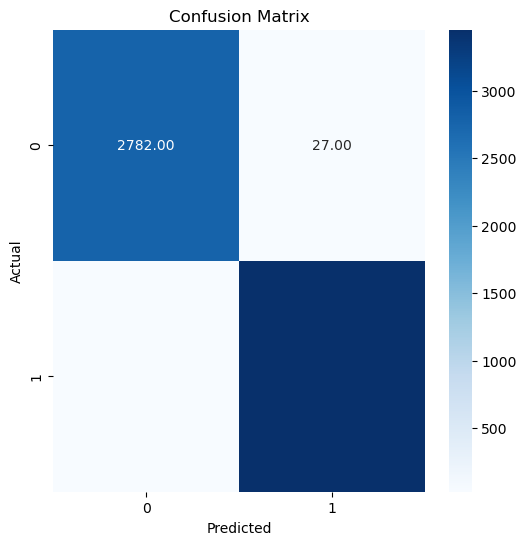

In [6]:
metrics.evaluate(final_model, 'Final Model', size)

**NOTE THE CONFUSION MATRIX BUGGED OUT AND I CURRENTLY LOOKING INTO WHY THIS HAPPENED :**

### Exporting
<hr style="border:2px solid MAGENTA">  

Saving the weights into this folder so we can load them up in the future. Printing out the metrics printout attribute.

In [7]:
final_model.save_weights('./Models_weights/CNN4_best')

In [8]:
metrics.printout.to_csv(f'Dataframes/{size}Final_Model.csv')

In [9]:
metrics.printout

,Model,Size,train log_loss,train accuracy,train TP,train TN,train FP,train FN,test log_loss,test accuracy,test TP,test TN,test FP,test FN,val log_loss,val accuracy,val TP,val TN,val FP,val FN
0,Final Model,224x224,0.027829,0.989653,15706.0,14231.0,269.0,44.0,0.032271,0.989683,3453.0,2782.0,38.0,27.0,0.037576,0.986349,3450.0,2764.0,56.0,30.0


We can see that the model performed very well on all the data!! YAY